## Importing libraries

In [ ]:
# import tensorflow as tf
import pandas as pd
#import requests
#import gzip
#import io
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install missingno
!pip install pandas tabulate
#!pip install xlsxwriter
!pip install openpyxl

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import missingno as msno
from tabulate import tabulate
import warnings
import gc
# from itertools import islice
# from openpyxl import load_workbook
# Filter out all warnings
warnings.filterwarnings("ignore")

In [ ]:
from wordcloud import WordCloud
from collections import Counter
# import string

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')
import url_batches
import util
import util_excel
import util_text_pre_process
from constants import TARGET_COLUMN, EXCEL_PATH

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
print(EXCEL_PATH)

/content/drive/MyDrive/output.xlsx


## Single set exploration

In [ ]:
# URL to the gzipped JSON file
url = 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz'
df = util.read_gzipped_json_from_url(url).reset_index(drop=True)

In [ ]:
print('Data shape: ', df.shape)

Data shape:  (169781, 12)


## Examining the Target column

In [ ]:
df[TARGET_COLUMN].value_counts()

5    135842
4     23143
3      6792
1      2192
2      1812
Name: overall, dtype: int64

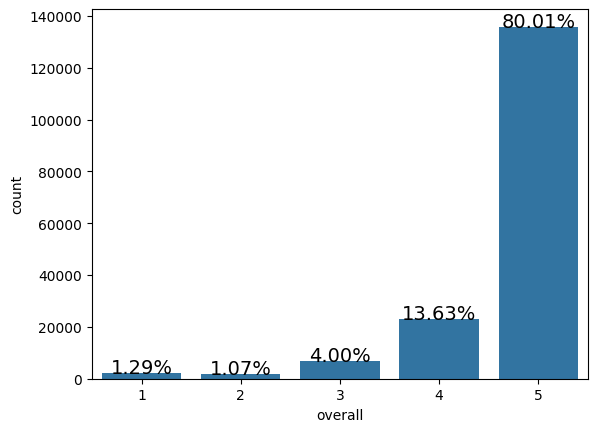

In [ ]:
# Create a count plot
s = sns.countplot(x=TARGET_COLUMN, data=df)
sizes = []

# Add percentage labels to the count plot
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x() + p.get_width() / 2.,
           height + 3,
           '{:1.2f}%'.format(height / len(df) * 100),
           ha="center", fontsize=14)

# Show the plot
plt.show()

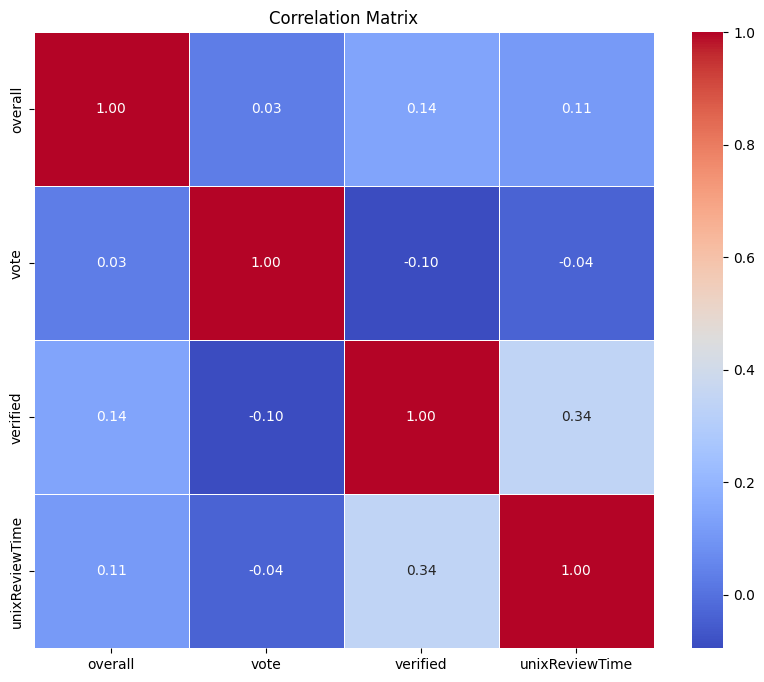

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Display information about the DataFrame, including data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         169781 non-null  int64  
 1   vote            7611 non-null    float64
 2   verified        169781 non-null  bool   
 3   reviewTime      169781 non-null  object 
 4   reviewerID      169781 non-null  object 
 5   asin            169781 non-null  object 
 6   style           157989 non-null  object 
 7   reviewerName    169776 non-null  object 
 8   reviewText      169623 non-null  object 
 9   summary         169745 non-null  object 
 10  unixReviewTime  169781 non-null  int64  
 11  image           182 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 14.4+ MB
None


In [ ]:
# Display data types of each column
print(df.dtypes)

overall             int64
vote              float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
image              object
dtype: object


In [ ]:
# Defining the features that are required along with the target column
df_small = df[['reviewerID','reviewText','summary', 'overall']]

## Detecting Missing values

In [ ]:
df_small.isnull().sum()

reviewerID      0
reviewText    158
summary        36
overall         0
dtype: int64

In [ ]:
def missing_values_table(df):
  # Total missing values
  mis_val = df.isnull().sum()

  # Percentage of missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df)

  # Make a table with the results
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

  # Rename the columns
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})

  # Sort the table by percentage of missing descending
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)

  # Print some summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

  # Return the dataframe with missing information
  return mis_val_table_ren_columns

In [ ]:
df_missing= missing_values_table(df_small)
df_missing

Your selected dataframe has 4 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
reviewText,158,0.1
summary,36,0.0


<Axes: >

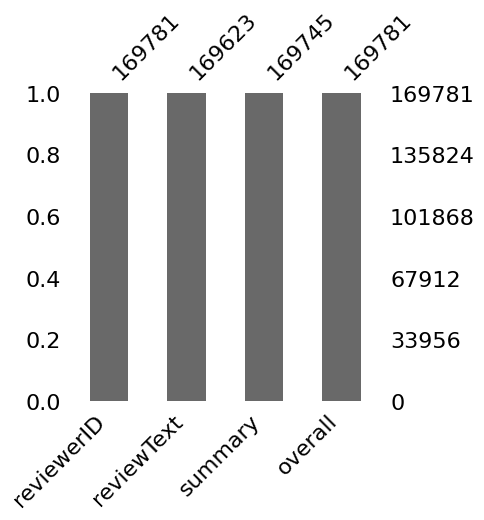

In [ ]:
msno.bar(df_small, figsize=(4, 4))

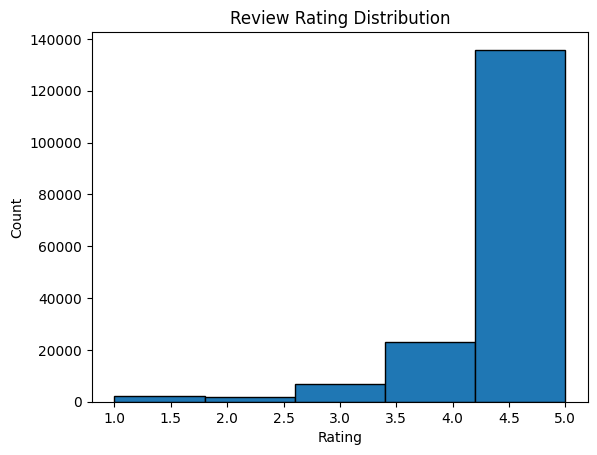

In [ ]:
# Create a histogram using Matplotlib
plt.hist(df_small['overall'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Review Rating Distribution')
plt.show()

## Multiple set exploration

In [ ]:
def check_product_category_imbalance(url_category_collection):
  # Specify the subset of columns
  required_columns = ['reviewText', 'summary', 'overall']

  result_table = pd.DataFrame()

  for url, category in url_category_collection.items():
    print(f"Processing category: {category}")
    df = util.read_gzipped_json_from_url(url)

    # Check if data was successfully retrieved
    if df is not None:
        df_small = df[required_columns]

        # Remove duplicate reviews based on the "reviewText" column
        df_no_duplicates, removed_duplicates_count = util_text_pre_process.remove_duplicate_reviews(df_small)
        print(f"Number of duplicate reviews removed for DataFrame {category}: {removed_duplicates_count}")

        # Check if there are any missing values
        has_missing, total_missing = util_text_pre_process.detect_missing_values(df_no_duplicates)
        # to do: add total_missing to a global collection

        if has_missing:
            print(f"There are missing values in the DataFrame for {category}. Total missing values: {total_missing}")
            # Remove rows with missing values based on the specified columns
            df_cleaned_no_duplicates = util_text_pre_process.remove_rows_with_missing_values(df_no_duplicates, *required_columns)
        else:
            print(f"There are no missing values in the DataFrame for {category}.")
            df_cleaned_no_duplicates = df_no_duplicates

        # Process data and update the result table
        result_table = util_text_pre_process.create_count_table(result_table, df_cleaned_no_duplicates, category)

        # Free up memory by releasing the DataFrame
        del df, df_small, df_no_duplicates, df_cleaned_no_duplicates
        # del chunk
        gc.collect()

  tabulated_data = tabulate(result_table, headers='keys', tablefmt='psql', showindex=False)
  print(tabulated_data)
  print('appending to excel...')
  util_excel.add_to_excel(result_table, EXCEL_PATH)
  print('appending completed.')

In [ ]:
check_product_category_imbalance(url_batches.url_batch_1)

Processing category: Amazon Fashion
Number of duplicate reviews removed for DataFrame Amazon Fashion: 2737
There are missing values in the DataFrame for Amazon Fashion. Total missing values: 1
Processing category: All Beauty
Number of duplicate reviews removed for DataFrame All Beauty: 3905
There are missing values in the DataFrame for All Beauty. Total missing values: 2
Processing category: Appliances
Number of duplicate reviews removed for DataFrame Appliances: 2133
There are no missing values in the DataFrame for Appliances.
Processing category: Arts, Crafts and Sewing
Number of duplicate reviews removed for DataFrame Arts, Crafts and Sewing: 141838
There are missing values in the DataFrame for Arts, Crafts and Sewing. Total missing values: 73
Processing category: Software
Number of duplicate reviews removed for DataFrame Software: 2199
There are missing values in the DataFrame for Software. Total missing values: 3
Processing category: Digital Music
Number of duplicate reviews remov

In [ ]:
check_product_category_imbalance(url_batches.url_batch_2)

Processing category: Automotive
Number of duplicate reviews removed for DataFrame Automotive: 363038
There are missing values in the DataFrame for Automotive. Total missing values: 233
Processing category: CDs and Vinyl
Number of duplicate reviews removed for DataFrame CDs and Vinyl: 209423
There are missing values in the DataFrame for CDs and Vinyl. Total missing values: 169
+---------------+---------+--------+--------+--------+-------+-------+
| Product       |   Total |      5 |      4 |      3 |     2 |     1 |
|---------------+---------+--------+--------+--------+-------+-------|
| CDs and Vinyl | 1228090 | 795939 | 246598 | 101513 | 43435 | 40605 |
| Automotive    | 1334920 | 931639 | 193518 |  89479 | 47520 | 72764 |
+---------------+---------+--------+--------+--------+-------+-------+
appending to excel...
appending completed.


In [ ]:
check_product_category_imbalance(url_batches.url_batch_3)

Processing category: Cell Phones and Accessories
Number of duplicate reviews removed for DataFrame Cell Phones and Accessories: 197212
There are missing values in the DataFrame for Cell Phones and Accessories. Total missing values: 353
Processing category: Grocery and Gourmet Food
Number of duplicate reviews removed for DataFrame Grocery and Gourmet Food: 255240
There are missing values in the DataFrame for Grocery and Gourmet Food. Total missing values: 123
Processing category: Industrial and Scientific
Number of duplicate reviews removed for DataFrame Industrial and Scientific: 18740
There are missing values in the DataFrame for Industrial and Scientific. Total missing values: 4
Processing category: Magazine Subscriptions
Number of duplicate reviews removed for DataFrame Magazine Subscriptions: 485
There are missing values in the DataFrame for Magazine Subscriptions. Total missing values: 3
Processing category: Musical Instruments
Number of duplicate reviews removed for DataFrame Mus

In [ ]:
check_product_category_imbalance(url_batches.url_batch_4)

Processing category: Toys and Games
Number of duplicate reviews removed for DataFrame Toys and Games: 367789
There are missing values in the DataFrame for Toys and Games. Total missing values: 270
+----------------+---------+--------+--------+--------+-------+-------+
| Product        |   Total |      5 |      4 |      3 |     2 |     1 |
|----------------+---------+--------+--------+--------+-------+-------|
| Toys and Games | 1448783 | 985878 | 233524 | 117435 | 53840 | 58106 |
+----------------+---------+--------+--------+--------+-------+-------+
appending to excel...
appending completed.


In [ ]:
check_product_category_imbalance(url_batches.url_batch_5)

Processing category: Tools and Home Improvement
Number of duplicate reviews removed for DataFrame Tools and Home Improvement: 396552
There are missing values in the DataFrame for Tools and Home Improvement. Total missing values: 195
+----------------------------+---------+---------+--------+--------+-------+-------+
| Product                    |   Total |       5 |      4 |      3 |     2 |     1 |
|----------------------------+---------+---------+--------+--------+-------+-------|
| Tools and Home Improvement | 1661662 | 1108430 | 275372 | 122612 | 66649 | 88599 |
+----------------------------+---------+---------+--------+--------+-------+-------+
appending to excel...
appending completed.


In [ ]:
check_product_category_imbalance(url_batches.url_batch_6)

Processing category: Pet Supplies
Number of duplicate reviews removed for DataFrame Pet Supplies: 372886
There are missing values in the DataFrame for Pet Supplies. Total missing values: 297
+--------------+---------+---------+--------+--------+-------+--------+
| Product      |   Total |       5 |      4 |      3 |     2 |      1 |
|--------------+---------+---------+--------+--------+-------+--------|
| Pet Supplies | 1715230 | 1099497 | 247439 | 156635 | 94132 | 117527 |
+--------------+---------+---------+--------+--------+-------+--------+
appending to excel...
appending completed.


## Preparing the main set

In [ ]:
def create_filtered_set(url_category_collection, rating_value, items_to_get, provide_all = False):
  required_columns = ['reviewText', 'summary', 'overall']

  df_scoped = pd.DataFrame()

  for url, category in url_category_collection.items():
    print(f"Processing category: {category}")
    df = util.read_gzipped_json_from_url(url)
    df_small = df[required_columns]
    #print(df_small.shape)

    df_no_duplicates, removed_duplicates_count = util_text_pre_process.remove_duplicate_reviews(df_small)

    has_missing, total_missing = util_text_pre_process.detect_missing_values(df_no_duplicates)

    if has_missing:
        df_cleaned_no_duplicates = util_text_pre_process.remove_rows_with_missing_values(df_no_duplicates, *required_columns)
    else:
        df_cleaned_no_duplicates = df_no_duplicates

    df_filtered = df_cleaned_no_duplicates[df_cleaned_no_duplicates['overall'] == rating_value]

    if provide_all == False:
      df_filtered_selected = df_filtered.sample(n=items_to_get, random_state=42)  # Set a random_state for reproducibility

    # Concatenate the scoped_data with the filtered_df
    df_scoped = pd.concat([df_scoped, df_filtered_selected], ignore_index=True)

  del df, df_small, df_no_duplicates, df_cleaned_no_duplicates, df_filtered, df_filtered_selected
  gc.collect()

  return df_scoped

### Preparing rating 5

Batch 1

In [ ]:
master_df_5 = create_filtered_set(url_batches.url_filter_batch_1, rating_value = 5, items_to_get = 1000)

Processing category: All Beauty
Processing category: Arts, Crafts and Sewing
Processing category: Software
Processing category: Digital Music
Processing category: Gift Cards


In [ ]:
master_df_5.shape

(5000, 3)

In [ ]:
master_df_5.head()

,reviewText,summary,overall
0,i stopped using soap when i started working in...,This one is different!,5
1,this set is awesome! i bought one for myself a...,This set is awesome! I bought one for myself a...,5
2,i was a little hesitant to order this clip but...,Love it!,5
3,i like all of the pre de provence soaps i've o...,Treat yourself,5
4,fast delivery and great product!!!!!!,Five Stars,5


Write to excel

In [ ]:
util_excel.add_to_excel(master_df_5, '/content/drive/MyDrive/aml_excel/df_rating_5.xlsx')

Batch 2

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_2, rating_value = 5, items_to_get = 1000)

Processing category: Automotive


In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)

In [ ]:
master_df_5.shape

(6000, 3)

In [ ]:
# del temp_df

Batch 3

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_3, rating_value = 5, items_to_get = 1000)

Processing category: CDs and Vinyl


In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)

In [ ]:
master_df_5.shape

(7000, 3)

Batch 4

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_4, rating_value = 5, items_to_get = 1000)
temp_df.shape

Processing category: Cell Phones and Accessories
Processing category: Grocery and Gourmet Food
Processing category: Industrial and Scientific
Processing category: Magazine Subscriptions
Processing category: Musical Instruments
Processing category: Office Products
Processing category: Patio, Lawn and Garden
Processing category: Prime Pantry


(8000, 3)

In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)
master_df_5.shape

(15000, 3)

Batch 5

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_5, rating_value = 5, items_to_get = 1000)
temp_df.shape

Processing category: Toys and Games


(1000, 3)

In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)
master_df_5.shape

(16000, 3)

Batch 6

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_6, rating_value = 5, items_to_get = 1000)
temp_df.shape

Processing category: Tools and Home Improvement


(1000, 3)

In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)
master_df_5.shape

(17000, 3)

Batch 7

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_7, rating_value = 5, items_to_get = 1000)
temp_df.shape

Processing category: Pet Supplies


(1000, 3)

In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)
master_df_5.shape

(18000, 3)

Batch 8 [nbu]

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_8, rating_value = 5, items_to_get = 230)
temp_df.shape

Processing category: Amazon Fashion


(230, 3)

In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)
master_df_5.shape

(5900, 3)

Batch 9 [nbu]

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_batch_9, rating_value = 5, items_to_get = 100)
temp_df.shape

Processing category: Appliances


(100, 3)

In [ ]:
master_df_5 = pd.concat([master_df_5, temp_df], ignore_index=True)
master_df_5.shape

(6000, 3)

Write to excel

In [ ]:
util_excel.add_to_excel(master_df_5, '/content/drive/MyDrive/aml_excel/rating_5.xlsx')

### Preparing rating 4

Batch 1

In [ ]:
master_df_4 = create_filtered_set(url_batches.url_filter_4_batch_1, rating_value = 4, items_to_get = 1200)

Processing category: Arts, Crafts and Sewing
Processing category: Software
Processing category: Digital Music


In [ ]:
master_df_4.shape

(3600, 3)

Batch 2

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_2, rating_value = 4, items_to_get = 1200)

Processing category: Automotive


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(4800, 3)

Batch 3

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_3, rating_value = 4, items_to_get = 1200)

Processing category: CDs and Vinyl


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(6000, 3)

Batch 4

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_4, rating_value = 4, items_to_get = 1200)

Processing category: Cell Phones and Accessories
Processing category: Grocery and Gourmet Food
Processing category: Industrial and Scientific
Processing category: Musical Instruments
Processing category: Office Products
Processing category: Patio, Lawn and Garden
Processing category: Prime Pantry


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(14400, 3)

Batch 5

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_5, rating_value = 4, items_to_get = 1200)

Processing category: Toys and Games


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(15600, 3)

Batch 6

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_6, rating_value = 4, items_to_get = 1200)

Processing category: Tools and Home Improvement


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(16800, 3)

Batch 7

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_7, rating_value = 4, items_to_get = 1200)

Processing category: Pet Supplies


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(18000, 3)

Batch 8 [nbu]

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_8, rating_value = 4, items_to_get = 100)

Processing category: All Beauty
Processing category: Gift Cards


Batch 9 (nbu)

In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(5825, 3)

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_9, rating_value = 4, items_to_get = 175)

Processing category: Magazine Subscriptions


In [ ]:
master_df_4 = pd.concat([master_df_4, temp_df], ignore_index=True)
master_df_4.shape

(6000, 3)

Writing to excel

In [ ]:
util_excel.add_to_excel(master_df_4, '/content/drive/MyDrive/aml_excel/rating_4.xlsx')

### Preparing rating 3

Batch 1

In [ ]:
master_df_3 = create_filtered_set(url_batches.url_filter_4_batch_1, rating_value = 3, items_to_get = 1200)
master_df_3.shape

Processing category: Arts, Crafts and Sewing
Processing category: Software
Processing category: Digital Music


(3600, 3)

Batch 2

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_2, rating_value = 3, items_to_get = 1200)

Processing category: Automotive


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(4800, 3)

Batch 3

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_3, rating_value = 3, items_to_get = 1200)

Processing category: CDs and Vinyl


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(6000, 3)

Batch 4

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_4, rating_value = 3, items_to_get = 1200)

Processing category: Cell Phones and Accessories
Processing category: Grocery and Gourmet Food
Processing category: Industrial and Scientific
Processing category: Musical Instruments
Processing category: Office Products
Processing category: Patio, Lawn and Garden
Processing category: Prime Pantry


In [ ]:
temp_df.shape

(8400, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(14400, 3)

Batch 5

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_5, rating_value = 3, items_to_get = 1200)

Processing category: Toys and Games


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(15600, 3)

Batch 6

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_6, rating_value = 3, items_to_get = 1200)

Processing category: Tools and Home Improvement


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(16800, 3)

Batch 7

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_7, rating_value = 3, items_to_get = 1200)

Processing category: Pet Supplies


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(18000, 3)

Batch 8 (nbu)

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_3_batch_8, rating_value = 3, items_to_get = 150)

Processing category: Magazine Subscriptions


In [ ]:
temp_df.shape

(150, 3)

In [ ]:
master_df_3 = pd.concat([master_df_3, temp_df], ignore_index=True)
master_df_3.shape

(6000, 3)

Writing to excel

In [ ]:
util_excel.add_to_excel(master_df_3, '/content/drive/MyDrive/aml_excel/rating_3.xlsx')

### Preparing rating 2

Batch 1

In [ ]:
master_df_2 = create_filtered_set(url_batches.url_filter_4_batch_0, rating_value = 2, items_to_get = 1286)
master_df_2.shape

Processing category: Arts, Crafts and Sewing
Processing category: Digital Music


(2572, 3)

Batch 2

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_2, rating_value = 2, items_to_get = 1286)

Processing category: Automotive


In [ ]:
temp_df.shape

(1286, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(3858, 3)

Batch 3

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_3, rating_value = 2, items_to_get = 1286)

Processing category: CDs and Vinyl


In [ ]:
temp_df.shape

(1286, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(5144, 3)

Batch 4

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_4, rating_value = 2, items_to_get = 1286)

Processing category: Cell Phones and Accessories
Processing category: Grocery and Gourmet Food
Processing category: Industrial and Scientific
Processing category: Musical Instruments
Processing category: Office Products
Processing category: Patio, Lawn and Garden
Processing category: Prime Pantry


In [ ]:
temp_df.shape

(9002, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(14146, 3)

Batch 5

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_5, rating_value = 2, items_to_get = 1286)

Processing category: Toys and Games


In [ ]:
temp_df.shape

(1286, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(15432, 3)

Batch 6

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_6, rating_value = 2, items_to_get = 1286)

Processing category: Tools and Home Improvement


In [ ]:
temp_df.shape

(1286, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(16718, 3)

Batch 7

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_7, rating_value = 2, items_to_get = 1286)

Processing category: Pet Supplies


In [ ]:
temp_df.shape

(1286, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(18004, 3)

Batch 8 (nbu)

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_3_batch_8, rating_value = 2, items_to_get = 90)

Processing category: Magazine Subscriptions


In [ ]:
temp_df.shape

(90, 3)

In [ ]:
master_df_2 = pd.concat([master_df_2, temp_df], ignore_index=True)
master_df_2.shape

(6000, 3)

Writing to excel

In [ ]:
util_excel.add_to_excel(master_df_2, '/content/drive/MyDrive/aml_excel/rating_2.xlsx')

### Preparing rating 1

Batch 1

In [ ]:
master_df_1 = create_filtered_set(url_batches.url_filter_4_batch_1, rating_value = 1, items_to_get = 1200)
master_df_1.shape

Processing category: Arts, Crafts and Sewing
Processing category: Software
Processing category: Digital Music


(3600, 3)

Batch 2

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_2, rating_value = 1, items_to_get = 1200)

Processing category: Automotive


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_1 = pd.concat([master_df_1, temp_df], ignore_index=True)
master_df_1.shape

(4800, 3)

Batch 3

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_3, rating_value = 1, items_to_get = 1200)

Processing category: CDs and Vinyl


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_1 = pd.concat([master_df_1, temp_df], ignore_index=True)
master_df_1.shape

(6000, 3)

Batch 4

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_4, rating_value = 1, items_to_get = 1200)

Processing category: Cell Phones and Accessories
Processing category: Grocery and Gourmet Food
Processing category: Industrial and Scientific
Processing category: Musical Instruments
Processing category: Office Products
Processing category: Patio, Lawn and Garden
Processing category: Prime Pantry


In [ ]:
temp_df.shape

(8400, 3)

In [ ]:
master_df_1 = pd.concat([master_df_1, temp_df], ignore_index=True)
master_df_1.shape

(14400, 3)

Batch 5

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_5, rating_value = 1, items_to_get = 1200)

Processing category: Toys and Games


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_1 = pd.concat([master_df_1, temp_df], ignore_index=True)
master_df_1.shape

(15600, 3)

Batch 6

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_6, rating_value = 1, items_to_get = 1200)

Processing category: Tools and Home Improvement


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_1 = pd.concat([master_df_1, temp_df], ignore_index=True)
master_df_1.shape

(16800, 3)

Batch 7

In [ ]:
temp_df = create_filtered_set(url_batches.url_filter_4_batch_7, rating_value = 1, items_to_get = 1200)

Processing category: Pet Supplies


In [ ]:
temp_df.shape

(1200, 3)

In [ ]:
master_df_1 = pd.concat([master_df_1, temp_df], ignore_index=True)
master_df_1.shape

(18000, 3)

Writing to excel

In [ ]:
util_excel.add_to_excel(master_df_1, '/content/drive/MyDrive/aml_excel/rating_1.xlsx')

# Exploring the merged set

In [ ]:
file_1 = '/content/drive/MyDrive/aml_excel/rating_1.xlsx'
file_2 = '/content/drive/MyDrive/aml_excel/rating_2.xlsx'
file_3 = '/content/drive/MyDrive/aml_excel/rating_3.xlsx'
file_4 = '/content/drive/MyDrive/aml_excel/rating_4.xlsx'
file_5 = '/content/drive/MyDrive/aml_excel/rating_5.xlsx'

excel_files = [file_1, file_2, file_3, file_4, file_5]

merged_df = pd.DataFrame()

for file in excel_files:
    df = pd.read_excel(file)
    merged_df = merged_df.append(df, ignore_index=True)

In [ ]:
merged_df.shape

(90004, 3)

In [ ]:
merged_df.head()

,reviewText,summary,overall
0,i didn't get to use this. it was broken when r...,One Star,1
1,this brand of acrylic craft paint has the wors...,This brand of acrylic craft paint has the wors...,1
2,i bought this for threading very small seed be...,Not Good for Beading Felted Projects,1
3,wanted to decorate some mugs for a mad hatter ...,Total Dud,1
4,caused air bubbles in the paint...tried differ...,bubbles,1


Check if there is any null

In [ ]:
merged_df.isnull().sum()

reviewText    4
summary       2
overall       0
dtype: int64

In [ ]:
merged_df.rename(columns={'summary  ': 'summary'}, inplace=True)

In [ ]:
merged_df = merged_df.dropna(subset=['reviewText', 'summary', 'overall'])
print(merged_df.shape)

(89998, 3)


### Removing html tags

In [ ]:
# Use str.contains and a regex to identify rows with HTML tags
html_mask = merged_df['reviewText'].str.contains(r'<.*?>', regex=True)

# Keep only rows without HTML tags
merged_df_removed_html = merged_df[~html_mask]

In [ ]:
merged_df_removed_html.shape

(89234, 3)

In [ ]:
util_excel.add_to_excel(merged_df_removed_html, '/content/drive/MyDrive/aml_excel/merged_df.xlsx')

### Distribution of 'overall'

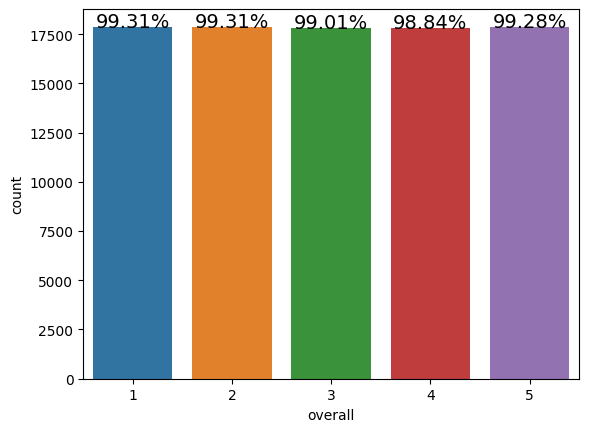

In [ ]:
# Create a count plot
s = sns.countplot(x = merged_df_removed_html['overall'], data = merged_df_removed_html)
sizes = []

# Add percentage labels to the count plot
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x() + p.get_width() / 2.,
           height + 3,
           '{:1.2f}%'.format(height / len(df) * 100),
           ha="center", fontsize=14)

# Show the plot
plt.show()

merged_df_removed_html

In [ ]:
util_excel.add_to_excel(merged_df_removed_html, '/content/drive/MyDrive/merged_df_removed_html.xlsx')

## Filling out the missings

From gift cards

In [ ]:
temp_df_1 = create_filtered_set(url_batches.url_1, rating_value = 3, items_to_get = 27)
html_mask_1 = temp_df_1['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_1 = temp_df_1[~html_mask_1]
temp_df_1.shape

Processing category: Gift Cards


(27, 3)

In [ ]:
temp_df_2 = create_filtered_set(url_batches.url_1, rating_value = 2, items_to_get = 10)
html_mask_2 = temp_df_2['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_2 = temp_df_2[~html_mask_2]
temp_df_2.shape

Processing category: Gift Cards


(10, 3)

In [ ]:
temp_df_3 = create_filtered_set(url_batches.url_1, rating_value = 1, items_to_get = 17)
html_mask_3 = temp_df_3['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_3 = temp_df_3[~html_mask_3]
temp_df_3.shape

Processing category: Gift Cards


(17, 3)

In [ ]:
temp_df_gifts = pd.concat([temp_df_1, temp_df_2, temp_df_3], ignore_index=True)
temp_df_gifts.shape

(54, 3)

Appliances

In [ ]:
temp_df_1 = create_filtered_set(url_batches.url_2, rating_value = 4, items_to_get = 12)
html_mask_1 = temp_df_1['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_1 = temp_df_1[~html_mask_1]
temp_df_1.shape

Processing category: Appliances


(12, 3)

In [ ]:
temp_df_2 = create_filtered_set(url_batches.url_2, rating_value = 3, items_to_get = 7)
html_mask_2 = temp_df_2['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_2 = temp_df_2[~html_mask_2]
temp_df_2.shape

Processing category: Appliances


(7, 3)

In [ ]:
temp_df_3 = create_filtered_set(url_batches.url_2, rating_value = 2, items_to_get = 7)
html_mask_3 = temp_df_3['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_3 = temp_df_3[~html_mask_3]
temp_df_3.shape

Processing category: Appliances


(7, 3)

In [ ]:
temp_df_4 = create_filtered_set(url_batches.url_2, rating_value = 1, items_to_get = 5)
html_mask_4 = temp_df_4['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_4 = temp_df_4[~html_mask_3]
temp_df_4.shape

Processing category: Appliances


(5, 3)

In [ ]:
temp_df_appliances = pd.concat([temp_df_1, temp_df_2, temp_df_3, temp_df_4], ignore_index=True)
temp_df_appliances.shape

(31, 3)

All beauty

In [ ]:
temp_df_1 = create_filtered_set(url_batches.url_3, rating_value = 3, items_to_get = 20)
html_mask_1 = temp_df_1['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_1 = temp_df_1[~html_mask_1]
temp_df_1.shape

Processing category: All Beauty


(20, 3)

In [ ]:
temp_df_2 = create_filtered_set(url_batches.url_3, rating_value = 2, items_to_get = 20)
html_mask_2 = temp_df_2['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_2 = temp_df_2[~html_mask_2]
temp_df_2.shape

Processing category: All Beauty


(19, 3)

In [ ]:
temp_df_3 = create_filtered_set(url_batches.url_3, rating_value = 1, items_to_get = 20)
html_mask_3 = temp_df_3['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_3 = temp_df_3[~html_mask_3]
temp_df_3.shape

Processing category: All Beauty


(20, 3)

In [ ]:
temp_df_all_beauty = pd.concat([temp_df_1, temp_df_2, temp_df_3], ignore_index=True)
temp_df_all_beauty.shape

(59, 3)

Amazon Fashion

In [ ]:
temp_df_1 = create_filtered_set(url_batches.url_4, rating_value = 3, items_to_get = 15)
html_mask_1 = temp_df_1['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_1 = temp_df_1[~html_mask_1]
temp_df_1.shape

Processing category: Amazon Fashion


(15, 3)

In [ ]:
temp_df_2 = create_filtered_set(url_batches.url_4, rating_value = 2, items_to_get = 15)
html_mask_2 = temp_df_2['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_2 = temp_df_2[~html_mask_2]
temp_df_2.shape

Processing category: Amazon Fashion


(15, 3)

In [ ]:
temp_df_3 = create_filtered_set(url_batches.url_4, rating_value = 1, items_to_get = 15)
html_mask_3 = temp_df_3['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_3 = temp_df_3[~html_mask_3]
temp_df_3.shape

Processing category: Amazon Fashion


(15, 3)

In [ ]:
temp_df_amazon_fashion = pd.concat([temp_df_1, temp_df_2, temp_df_3], ignore_index=True)
temp_df_amazon_fashion.shape

(45, 3)

Magazine Subscriptions

In [ ]:
temp_df_1 = create_filtered_set(url_batches.url_5, rating_value = 1, items_to_get = 78)
html_mask_1 = temp_df_1['reviewText'].str.contains(r'<.*?>', regex=True)
temp_df_1 = temp_df_1[~html_mask_1]
temp_df_1.shape

Processing category: Magazine Subscriptions


(76, 3)

In [ ]:
temp_df_magazine_subs = pd.concat([temp_df_1], ignore_index=True)
temp_df_magazine_subs.shape

(76, 3)

## Merge rest

In [ ]:
df_merge_rest = pd.concat([temp_df_gifts, temp_df_appliances, temp_df_all_beauty, temp_df_amazon_fashion, temp_df_magazine_subs], ignore_index=True)
df_merge_rest.shape

(265, 3)

Append to removed html excel

In [ ]:
util_excel.add_to_excel(df_merge_rest, '/content/drive/MyDrive/merged_df_removed_html.xlsx')

Store the merged df for rest

In [ ]:
util_excel.add_to_excel(df_merge_rest, '/content/drive/MyDrive/merged_df_rest.xlsx')

## Exploring cleaned data

In [ ]:
df_cleaned_html = pd.read_excel('/content/drive/MyDrive/aml_excel/merged_df.xlsx')

In [ ]:
df_cleaned_html.shape

(89234, 3)

In [ ]:
df_cleaned_html.isnull().sum()

reviewText    0
summary       0
overall       0
dtype: int64

In [ ]:
df_cleaned_html.head()

,reviewText,summary,overall
0,i didn't get to use this. it was broken when r...,One Star,1
1,this brand of acrylic craft paint has the wors...,This brand of acrylic craft paint has the wors...,1
2,i bought this for threading very small seed be...,Not Good for Beading Felted Projects,1
3,wanted to decorate some mugs for a mad hatter ...,Total Dud,1
4,caused air bubbles in the paint...tried differ...,bubbles,1


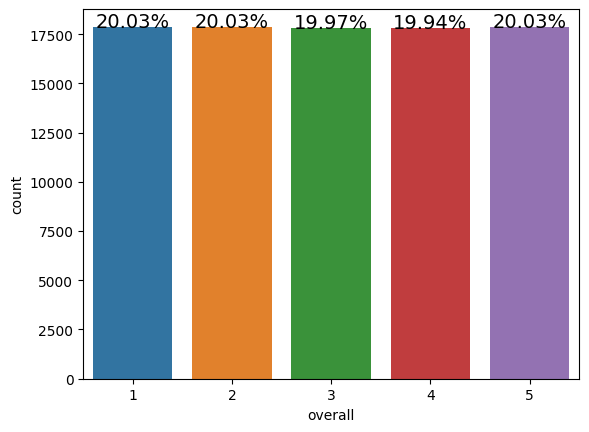

In [ ]:
# Create a count plot
s = sns.countplot(x=df_cleaned_html['overall'], data=df_cleaned_html)
sizes = []

# Add percentage labels to the count plot
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x() + p.get_width() / 2.,
           height + 3,
           '{:1.2f}%'.format(height / len(df_cleaned_html) * 100),
           ha="center", fontsize=14)

# Show the plot
plt.show()

## Experimental: show value count of the target column

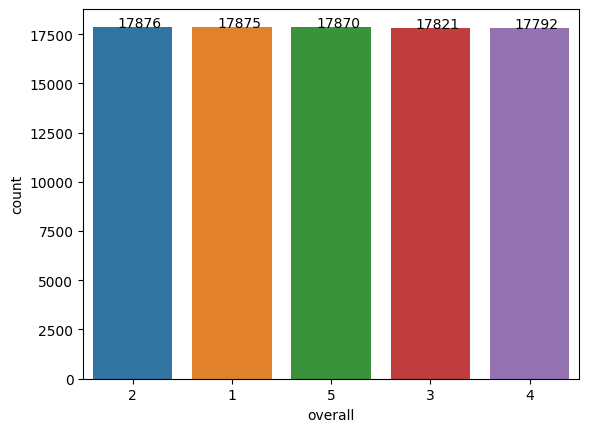

In [ ]:
# plt.figure(figsize=(10, 10))

ax = sns.countplot(x = df_cleaned_html['overall'], data = df_cleaned_html, order = df_cleaned_html['overall'].value_counts().index)

for p, label in zip(ax.patches, df_cleaned_html['overall'].value_counts()):
  ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5))

In [ ]:
df_rating_1 = df_cleaned_html[df_cleaned_html['overall'] == 1].copy()
df_rating_2 = df_cleaned_html[df_cleaned_html['overall'] == 2].copy()
df_rating_3 = df_cleaned_html[df_cleaned_html['overall'] == 3].copy()
df_rating_4 = df_cleaned_html[df_cleaned_html['overall'] == 4].copy()
df_rating_5 = df_cleaned_html[df_cleaned_html['overall'] == 5].copy()

In [ ]:
print(f"Rating 1: {len(df_rating_1)}")
print(f"Rating 2: {len(df_rating_2)}")
print(f"Rating 3: {len(df_rating_3)}")
print(f"Rating 4: {len(df_rating_4)}")
print(f"Rating 5: {len(df_rating_5)}")

Rating 1: 17875
Rating 2: 17876
Rating 3: 17821
Rating 4: 17792
Rating 5: 17870


## Pre-processing of reviewText

In [ ]:
# process text for rating 1
df_rating_1['reviewText'] = df_rating_1['reviewText'].apply(util_text_pre_process.clean_text)
df_rating_1['reviewText'] = df_rating_1['reviewText'].apply(util_text_pre_process.remove_stopwords)
df_rating_1['reviewText'] = df_rating_1['reviewText'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# print the value of a single item
print(df_rating_1.loc[0, 'reviewText'])

didnt get use broken received


In [ ]:
# process text for rating 2
df_rating_2['reviewText'] = df_rating_2['reviewText'].apply(util_text_pre_process.clean_text)
df_rating_2['reviewText'] = df_rating_2['reviewText'].apply(util_text_pre_process.remove_stopwords)
df_rating_2['reviewText'] = df_rating_2['reviewText'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
print(df_rating_2.iloc[0])

reviewText    nice size poorly made even sit level table qua...
summary                        Disappointing, very poor quality
overall                                                       2
Name: 5961, dtype: object


In [ ]:
df_rating_2.index

Int64Index([ 5961,  5962,  5963,  5964,  5965,  5966,  5967,  5968,  5969,
             5970,
            ...
            29899, 29900, 29901, 29902, 29903, 29904, 29905, 29906, 29907,
            29908],
           dtype='int64', length=5992)

In [ ]:
df_rating_2.loc[5961, "reviewText"]

'nice size poorly made even sit level table quality product would never buy dirt inside wrapper earth leaf top big escape bearly stick pin top little room reason cheap point sending back would cost much dritiz used better buy update kept little strawberry sharpen needle pin cushion poor threw away inserted needle strawberry needle made hole filling started coming year ago would never would happened one least 20 year old fabric used currently make pin cushion low density make buy pink velvet one'

In [ ]:
# process text for rating 3
df_rating_3['reviewText'] = df_rating_3['reviewText'].apply(util_text_pre_process.clean_text)
df_rating_3['reviewText'] = df_rating_3['reviewText'].apply(util_text_pre_process.remove_stopwords)
df_rating_3['reviewText'] = df_rating_3['reviewText'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# process text for rating 4
df_rating_4['reviewText'] = df_rating_4['reviewText'].apply(util_text_pre_process.clean_text)
df_rating_4['reviewText'] = df_rating_4['reviewText'].apply(util_text_pre_process.remove_stopwords)
df_rating_4['reviewText'] = df_rating_4['reviewText'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# process text for rating 5
df_rating_5['reviewText'] = df_rating_5['reviewText'].apply(util_text_pre_process.clean_text)
df_rating_5['reviewText'] = df_rating_5['reviewText'].apply(util_text_pre_process.remove_stopwords)
df_rating_5['reviewText'] = df_rating_5['reviewText'].apply(util_text_pre_process.lemmatize_text)

## Info on review words

In [ ]:
df_rating_1['numberofWords'] = df_rating_1['reviewText'].apply(lambda x: len(str(x).split()))

In [ ]:
df_rating_2['numberofWords'] = df_rating_2['reviewText'].apply(lambda x: len(str(x).split()))

In [ ]:
df_rating_3['numberofWords'] = df_rating_3['reviewText'].apply(lambda x: len(str(x).split()))

In [ ]:
df_rating_4['numberofWords'] = df_rating_4['reviewText'].apply(lambda x: len(str(x).split()))

In [ ]:
df_rating_5['numberofWords'] = df_rating_5['reviewText'].apply(lambda x: len(str(x).split()))

In [ ]:
pd.DataFrame(df_rating_1['numberofWords'].describe())

,numberofWords
count,17875.000000
mean,36.071664
std,61.293426
min,0.000000
25%,9.000000
50%,19.000000
75%,41.000000
max,2101.000000


In [ ]:
description_table = df_rating_1['numberofWords'].describe().reset_index()
description_table.columns = ['Statistic', 'Value']

# Use tabulate to print the table
print(tabulate(description_table, headers='keys', tablefmt='pretty', showindex=False))

+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |       6094.0       |
|   mean    | 35.155070561207744 |
|    std    | 51.24134502912506  |
|    min    |        0.0         |
|    25%    |        9.0         |
|    50%    |        19.0        |
|    75%    |        41.0        |
|    max    |       1056.0       |
+-----------+--------------------+


In [ ]:
pd.DataFrame(df_rating_2['numberofWords'].describe())

,numberofWords
count,17876.000000
mean,35.144439
std,50.192806
min,0.000000
25%,9.000000
50%,19.000000
75%,41.000000
max,970.000000


In [ ]:
pd.DataFrame(df_rating_3['numberofWords'].describe())

,numberofWords
count,17821.000000
mean,39.571910
std,74.859917
min,0.000000
25%,8.000000
50%,18.000000
75%,42.000000
max,2858.000000


In [ ]:
pd.DataFrame(df_rating_4['numberofWords'].describe())

,numberofWords
count,17792.000000
mean,39.632644
std,67.323008
min,0.000000
25%,8.000000
50%,17.000000
75%,43.000000
max,1736.000000


In [ ]:
pd.DataFrame(df_rating_5['numberofWords'].describe())

,numberofWords
count,17870.000000
mean,26.690655
std,52.576342
min,0.000000
25%,5.000000
50%,12.000000
75%,26.750000
max,3101.000000


## Info on reviwew sentences

In [ ]:
df_rating_1['numberofSentences'] = df_rating_1['reviewText'].apply(lambda x: len(sent_tokenize(str(x))))

In [ ]:
df_rating_2['numberofSentences'] = df_rating_2['reviewText'].apply(lambda x: len(sent_tokenize(str(x))))

In [ ]:
df_rating_3['numberofSentences'] = df_rating_3['reviewText'].apply(lambda x: len(sent_tokenize(str(x))))

In [ ]:
df_rating_4['numberofSentences'] = df_rating_4['reviewText'].apply(lambda x: len(sent_tokenize(str(x))))

In [ ]:
df_rating_5['numberofSentences'] = df_rating_5['reviewText'].apply(lambda x: len(sent_tokenize(str(x))))

In [ ]:
pd.DataFrame(df_rating_1['numberofSentences'].describe())

,numberofSentences
count,17875.000000
mean,0.999497
std,0.022434
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
pd.DataFrame(df_rating_2['numberofSentences'].describe())

,numberofSentences
count,17876.000000
mean,0.999664
std,0.018318
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
pd.DataFrame(df_rating_3['numberofSentences'].describe())

,numberofSentences
count,17821.000000
mean,0.999607
std,0.019816
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
pd.DataFrame(df_rating_4['numberofSentences'].describe())

,numberofSentences
count,17792.000000
mean,0.999719
std,0.016762
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
pd.DataFrame(df_rating_5['numberofSentences'].describe())

,numberofSentences
count,17870.000000
mean,0.999552
std,0.021154
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Info on review lenght

In [ ]:
df_rating_1['reviewLength'] = df_rating_1['reviewText'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_2['reviewLength'] = df_rating_2['reviewText'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_3['reviewLength'] = df_rating_3['reviewText'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_4['reviewLength'] = df_rating_4['reviewText'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_5['reviewLength'] = df_rating_5['reviewText'].apply(lambda x: len(str(x)))

In [ ]:
pd.DataFrame(df_rating_1['reviewLength'].describe())

,reviewLength
count,17875.000000
mean,233.510154
std,412.173464
min,0.000000
25%,54.000000
50%,118.000000
75%,260.000000
max,13768.000000


In [ ]:
pd.DataFrame(df_rating_2['reviewLength'].describe())

,reviewLength
count,17876.000000
mean,225.809353
std,331.961326
min,0.000000
25%,54.000000
50%,120.000000
75%,265.000000
max,6647.000000


In [ ]:
pd.DataFrame(df_rating_3['reviewLength'].describe())

,reviewLength
count,17821.000000
mean,256.814937
std,499.802661
min,0.000000
25%,51.000000
50%,113.000000
75%,267.000000
max,18949.000000


In [ ]:
pd.DataFrame(df_rating_4['reviewLength'].describe())

,reviewLength
count,17792.000000
mean,257.094031
std,450.627826
min,0.000000
25%,48.000000
50%,109.000000
75%,271.000000
max,11192.000000


In [ ]:
pd.DataFrame(df_rating_5['reviewLength'].describe())

,reviewLength
count,17870.000000
mean,172.926133
std,342.883493
min,0.000000
25%,33.000000
50%,75.000000
75%,168.000000
max,17487.000000


## Mean review length distribution

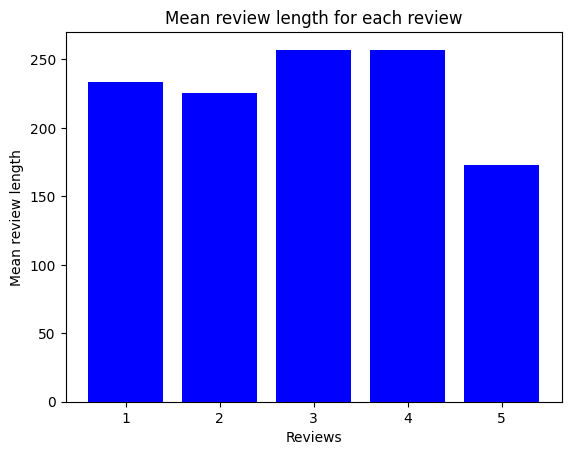

In [ ]:
mean_values = [
    df_rating_1['reviewLength'].mean(),
    df_rating_2['reviewLength'].mean(),
    df_rating_3['reviewLength'].mean(),
    df_rating_4['reviewLength'].mean(),
    df_rating_5['reviewLength'].mean()
]

# Create a bar graph
dataframe_labels = ['1', '2', '3', '4', '5']
# plt.figure(figsize=(10, 6))
plt.bar(dataframe_labels, mean_values, color='blue')
plt.xlabel('Reviews')
plt.ylabel('Mean review length')
plt.title('Mean review length for each review')
plt.show()

In [ ]:
df_rating_1.columns

Index(['reviewText', 'summary  ', 'overall', 'numberofWords',
       'numberofSentences', 'reviewLength'],
      dtype='object')

## Info on summary length

In [ ]:
df_rating_1['summaryLength'] = df_rating_1['summary'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_2['summaryLength'] = df_rating_2['summary'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_3['summaryLength'] = df_rating_3['summary'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_4['summaryLength'] = df_rating_4['summary'].apply(lambda x: len(str(x)))

In [ ]:
df_rating_5['summaryLength'] = df_rating_5['summary'].apply(lambda x: len(str(x)))

In [ ]:
pd.DataFrame(df_rating_1['summaryLength'].describe())

,summaryLength
count,17875.000000
mean,27.613986
std,21.625670
min,1.000000
25%,10.000000
50%,21.000000
75%,39.000000
max,161.000000


In [ ]:
pd.DataFrame(df_rating_2['summaryLength'].describe())

,summaryLength
count,17876.000000
mean,27.949206
std,20.956485
min,1.000000
25%,11.000000
50%,22.000000
75%,39.000000
max,166.000000


In [ ]:
pd.DataFrame(df_rating_3['summaryLength'].describe())

,summaryLength
count,17821.000000
mean,29.000673
std,21.264425
min,1.000000
25%,11.000000
50%,23.000000
75%,41.000000
max,147.000000


In [ ]:
pd.DataFrame(df_rating_4['summaryLength'].describe())

,summaryLength
count,17792.000000
mean,27.397089
std,20.793988
min,1.000000
25%,10.000000
50%,21.000000
75%,38.000000
max,204.000000


In [ ]:
pd.DataFrame(df_rating_5['summaryLength'].describe())

,summaryLength
count,17870.000000
mean,23.708002
std,18.772679
min,2.000000
25%,10.000000
50%,17.000000
75%,32.000000
max,128.000000


## Mean summary length distribution

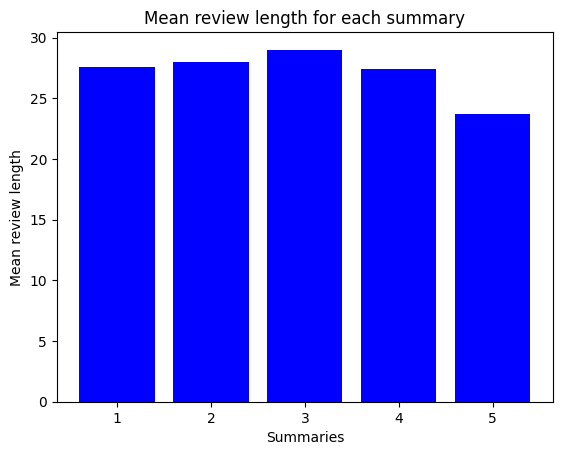

In [ ]:
mean_values = [
    df_rating_1['summaryLength'].mean(),
    df_rating_2['summaryLength'].mean(),
    df_rating_3['summaryLength'].mean(),
    df_rating_4['summaryLength'].mean(),
    df_rating_5['summaryLength'].mean()
]

# Create a bar graph
dataframe_labels = ['1', '2', '3', '4', '5']
# plt.figure(figsize=(10, 6))
plt.bar(dataframe_labels, mean_values, color='blue')
plt.xlabel('Summaries')
plt.ylabel('Mean review length')
plt.title('Mean review length for each summary')
plt.show()

## Frequent words for reviewText

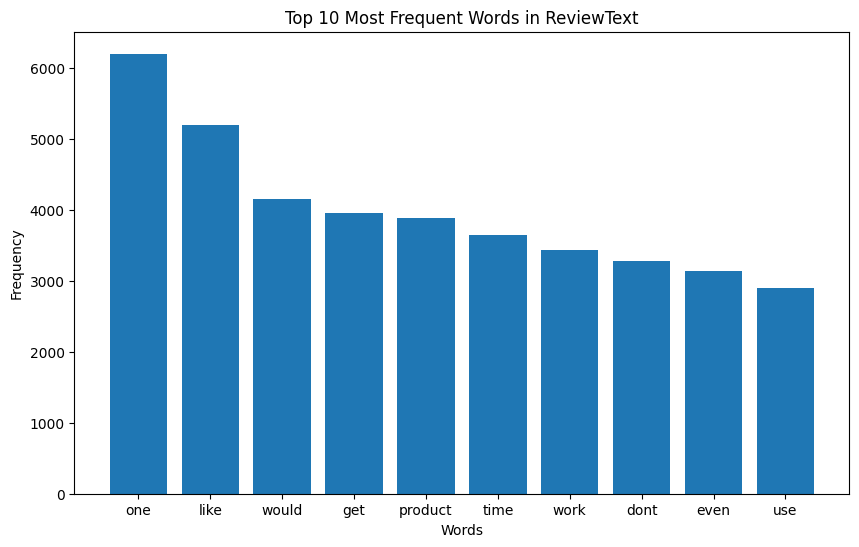

In [ ]:
# Counting word frequencies
word_freq = Counter(' '.join(df_rating_1['reviewText']).split())

# Top N words
top_words = word_freq.most_common(10)  # Change 10 to the desired number of top words

# Visualization using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(*zip(*top_words))
plt.title('Top 10 Most Frequent Words in ReviewText')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
word_freq_1 = df_rating_1['reviewText'].str.split(expand=True).stack().value_counts()

word_freq_1_top_100 = word_freq_1[:100]

word_freq_1_top_100.index

Index(['one', 'like', 'would', 'get', 'product', 'time', 'work', 'dont',
       'even', 'use', 'good', 'buy', 'back', 'song', 'year', 'make', 'money',
       'first', 'really', 'im', 'much', 'bought', 'got', 'way', 'could',
       'well', 'album', 'new', 'thing', 'used', 'review', 'didnt', 'problem',
       'go', 'two', 'made', 'never', 'better', 'day', 'also', '2', 'doesnt',
       'bad', 'amazon', 'cant', 'still', 'tried', 'great', 'know', 'window',
       'quality', 'say', 'box', 'want', 'look', 'need', 'music', 'another',
       'put', 'ive', 'software', 'version', 'sound', 'month', 'using', 'see',
       'return', 'something', 'try', 'right', 'waste', 'piece', 'little',
       'nothing', '3', 'come', 'old', 'think', 'many', 'item', 'going',
       'since', 'phone', 'plastic', 'fit', 'take', 'cheap', '1', 'last',
       'every', 'cd', 'taste', 'ever', 'give', 'star', 'program', 'update',
       'printer', 'price', 'find'],
      dtype='object')

In [ ]:
fig = px.treemap(word_freq_1_top_100, path=[word_freq_1_top_100.index], values=0)

fig.update_layout(title_text = 'Top 100 frequent words for overall 1', title_x = 0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')
fig.show()

In [ ]:
word_freq_2 = df_rating_2['reviewText'].str.split(expand=True).stack().value_counts()
word_freq_2_top_100 = word_freq_2[:100]

fig = px.treemap(word_freq_2_top_100, path=[word_freq_2_top_100.index], values=0)

fig.update_layout(title_text = 'Top 100 frequent words for overall 2', title_x = 0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')
fig.show()

In [ ]:
word_freq_3 = df_rating_3['reviewText'].str.split(expand=True).stack().value_counts()
word_freq_3_top_100 = word_freq_3[:100]

fig = px.treemap(word_freq_3_top_100, path=[word_freq_3_top_100.index], values=0)

fig.update_layout(title_text = 'Top 100 frequent words for overall 3', title_x = 0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')
fig.show()

In [ ]:
word_freq_4 = df_rating_4['reviewText'].str.split(expand=True).stack().value_counts()
word_freq_4_top_100 = word_freq_4[:100]

fig = px.treemap(word_freq_4_top_100, path=[word_freq_4_top_100.index], values=0)

fig.update_layout(title_text = 'Top 100 frequent words for overall 4', title_x = 0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')
fig.show()

In [ ]:
word_freq_5 = df_rating_5['reviewText'].str.split(expand=True).stack().value_counts()
word_freq_5_top_100 = word_freq_5[:100]

fig = px.treemap(word_freq_5_top_100, path=[word_freq_5_top_100.index], values=0)

fig.update_layout(title_text = 'Top 100 frequent words for overall 5', title_x = 0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')
fig.show()

## Pre-processing of summary

## Correction of the summary column name

In [ ]:
df_rating_1.rename(columns={'summary  ': 'summary'}, inplace=True)
df_rating_2.rename(columns={'summary  ': 'summary'}, inplace=True)
df_rating_3.rename(columns={'summary  ': 'summary'}, inplace=True)
df_rating_4.rename(columns={'summary  ': 'summary'}, inplace=True)
df_rating_5.rename(columns={'summary  ': 'summary'}, inplace=True)

In [ ]:
# processing summary for rating 1
df_rating_1['summary'] = df_rating_1['summary'].apply(util_text_pre_process.clean_text)
df_rating_1['summary'] = df_rating_1['summary'].apply(util_text_pre_process.remove_stopwords)
df_rating_1['summary'] = df_rating_1['summary'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# processing summary for rating 2
df_rating_2['summary'] = df_rating_2['summary'].apply(util_text_pre_process.clean_text)
df_rating_2['summary'] = df_rating_2['summary'].apply(util_text_pre_process.remove_stopwords)
df_rating_2['summary'] = df_rating_2['summary'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# processing summary for rating 3
df_rating_3['summary'] = df_rating_3['summary'].apply(util_text_pre_process.clean_text)
df_rating_3['summary'] = df_rating_3['summary'].apply(util_text_pre_process.remove_stopwords)
df_rating_3['summary'] = df_rating_3['summary'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# processing summary for rating 4
df_rating_4['summary'] = df_rating_4['summary'].apply(util_text_pre_process.clean_text)
df_rating_4['summary'] = df_rating_4['summary'].apply(util_text_pre_process.remove_stopwords)
df_rating_4['summary'] = df_rating_4['summary'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# processing summary for rating 5
df_rating_5['summary'] = df_rating_5['summary'].apply(util_text_pre_process.clean_text)
df_rating_5['summary'] = df_rating_5['summary'].apply(util_text_pre_process.remove_stopwords)
df_rating_5['summary'] = df_rating_5['summary'].apply(util_text_pre_process.lemmatize_text)

## Word cloud for summary

In [ ]:
# wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(df_rating_1['summary'].tolist()))
# plt.figure(figsize=(20, 10), facecolor='k')
# plt.imshow(wordcloud)

### Rating 1

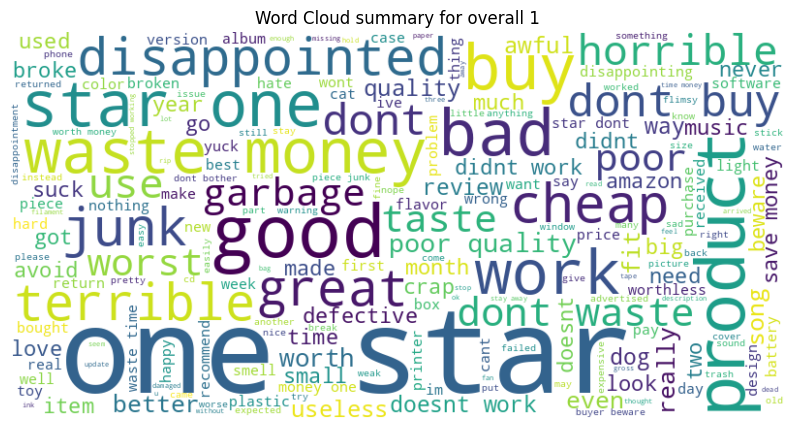

In [ ]:
# Generate the word cloud for summary
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_rating_1['summary'].tolist()))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud summary for overall 1')
plt.show()

### Rating 2

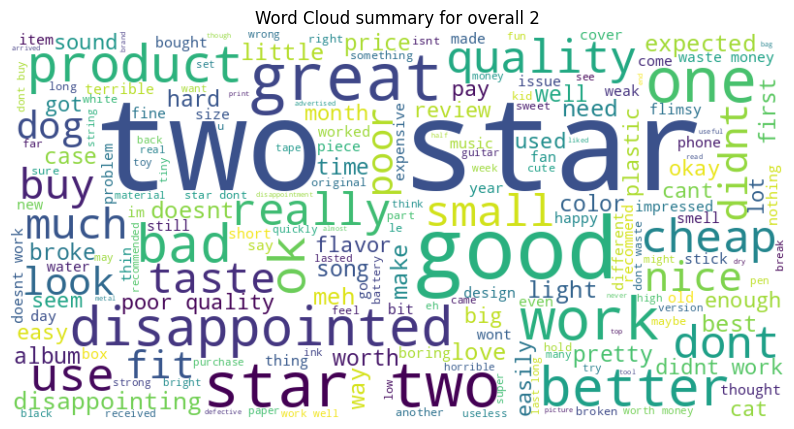

In [ ]:
# Generate the word cloud for summary
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_rating_2['summary'].tolist()))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud summary for overall 2')
plt.show()

### Rating 3

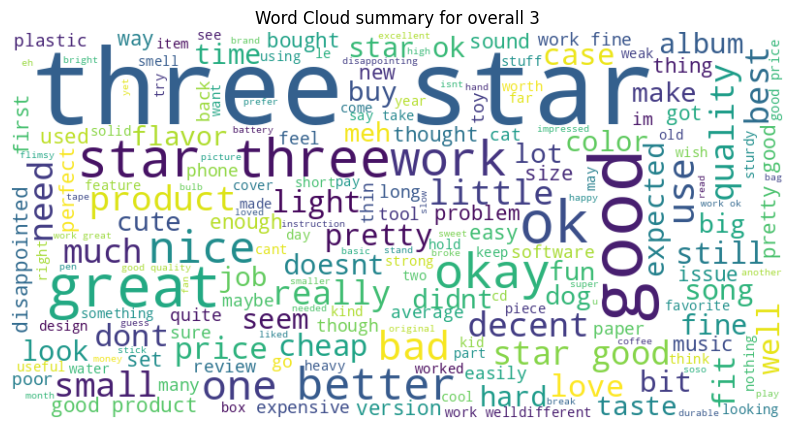

In [ ]:
# Generate the word cloud for summary
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_rating_3['summary'].tolist()))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud summary for overall 3')
plt.show()

### Rating 4

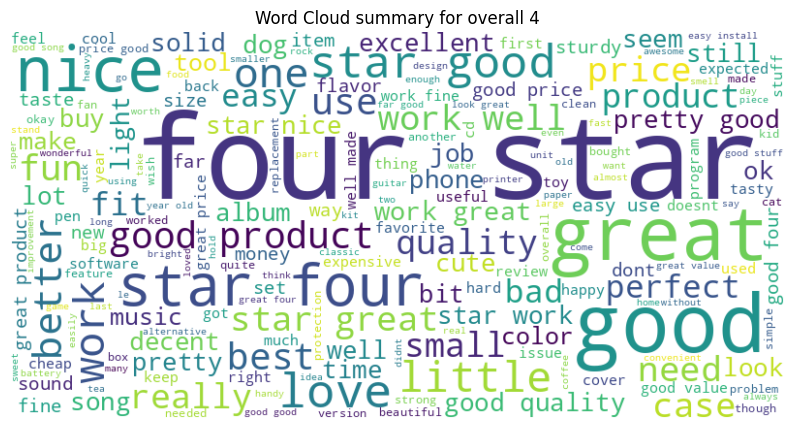

In [ ]:
# Generate the word cloud for summary
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_rating_4['summary'].tolist()))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud summary for overall 4')
plt.show()

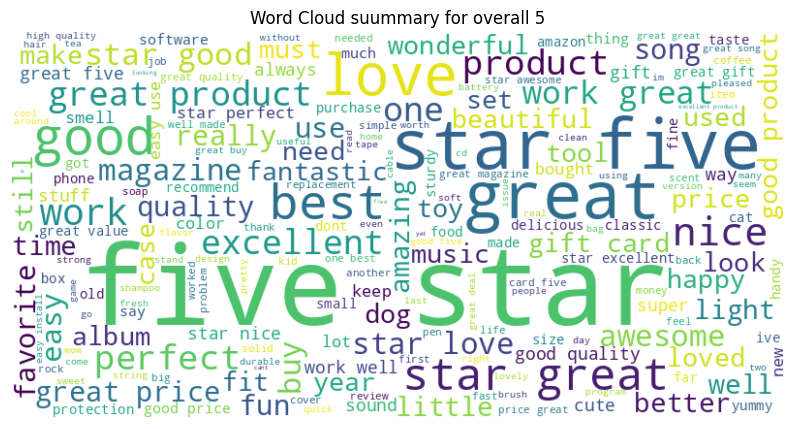

In [ ]:
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_rating_5['summary'].tolist()))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud suummary for overall 5')
plt.show()

## Merging pre-processed data-frames

In [ ]:
df_pre_processed = pd.concat([df_rating_1, df_rating_2, df_rating_3, df_rating_4, df_rating_5], ignore_index=True)
df_pre_processed.shape

(89234, 7)

In [ ]:
df_pre_processed.isnull().sum()

reviewText           0
summary              0
overall              0
numberofWords        0
numberofSentences    0
reviewLength         0
summaryLength        0
dtype: int64

In [ ]:
util_excel.add_to_excel(df_pre_processed, '/content/drive/MyDrive/aml_excel/corpus-small.xlsx')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/aml_excel/pre_processed_data.xlsx')

## Preparing test data

In [ ]:
check_product_category_imbalance(url_batches.url_6)

Processing category: Luxury Beauty
Number of duplicate reviews removed for DataFrame Luxury Beauty: 10032
There are missing values in the DataFrame for Luxury Beauty. Total missing values: 5
+---------------+---------+-------+------+------+------+-----+
| Product       |   Total |     5 |    4 |    3 |    2 |   1 |
|---------------+---------+-------+------+------+------+-----|
| Luxury Beauty |   24156 | 12861 | 6345 | 3110 | 1131 | 709 |
+---------------+---------+-------+------+------+------+-----+
appending to excel...
appending completed.


In [ ]:
test_df_5 = create_filtered_set(url_batches.url_6, rating_value = 5, items_to_get = 12861)
test_df_5.shape

Processing category: Luxury Beauty


(12861, 3)

In [ ]:
test_df_4 = create_filtered_set(url_batches.url_6, rating_value = 4, items_to_get = 6345)
test_df_4.shape

Processing category: Luxury Beauty


(6345, 3)

In [ ]:
test_df_3 = create_filtered_set(url_batches.url_6, rating_value = 3, items_to_get = 3110)
test_df_3.shape

Processing category: Luxury Beauty


(3110, 3)

In [ ]:
test_df_2 = create_filtered_set(url_batches.url_6, rating_value = 2, items_to_get = 1131)
test_df_2.shape

Processing category: Luxury Beauty


(1131, 3)

In [ ]:
test_df_1 = create_filtered_set(url_batches.url_6, rating_value = 1, items_to_get = 709)
test_df_1.shape

Processing category: Luxury Beauty


(709, 3)

In [ ]:
master_test_df = pd.concat([test_df_1, test_df_2, test_df_3, test_df_4, test_df_5], ignore_index=True)
master_test_df.shape

(24156, 3)

# Detecting and removing missing values

In [ ]:
pd.DataFrame(master_test_df.isnull().sum())

,0
reviewText,0
summary,0
overall,0


In [ ]:
df_missing_test= missing_values_table(master_test_df)
df_missing_test

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
master_test_df = master_test_df.dropna(subset=['reviewText', 'summary', 'overall'])
print(master_test_df.shape)

(24156, 3)


## Remove html tags

In [ ]:
# Use str.contains and a regex to identify rows with HTML tags
html_mask = master_test_df['reviewText'].str.contains(r'<.*?>', regex=True)

# Keep only rows without HTML tags
master_test_df_removed_html = master_test_df[~html_mask]

master_test_df_removed_html.shape

(23797, 3)

## Pre-processing ot test data set

In [ ]:
# processing review text
master_test_df_removed_html['reviewText'] = master_test_df_removed_html['reviewText'].apply(util_text_pre_process.clean_text)
master_test_df_removed_html['reviewText'] = master_test_df_removed_html['reviewText'].apply(util_text_pre_process.remove_stopwords)
master_test_df_removed_html['reviewText'] = master_test_df_removed_html['reviewText'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
# processing summary
master_test_df_removed_html['summary'] = master_test_df_removed_html['summary'].apply(util_text_pre_process.clean_text)
master_test_df_removed_html['summary'] = master_test_df_removed_html['summary'].apply(util_text_pre_process.remove_stopwords)
master_test_df_removed_html['summary'] = master_test_df_removed_html['summary'].apply(util_text_pre_process.lemmatize_text)

In [ ]:
master_test_df_removed_html.shape

(23797, 3)

## Writing to excel

In [ ]:
util_excel.add_to_excel(master_test_df_removed_html, '/content/drive/MyDrive/pre_processed_data_test.xlsx')